## Step 1 Install cx_Oracle

In [1]:
from txt2hpo.extract import Extractor
extract = Extractor(remove_overlapping=False)
result = extract.hpo("diarrhea and encehphalopathy")

2021-03-07 23:32:04,232 - phenopy - INFO - checking if config file exists: /home/havrillaj/.phenopy
2021-03-07 23:32:04,238 - phenopy - INFO - phenopy 0.5.2
2021-03-07 23:32:04,242 - phenopy - INFO - Using configuration file: /home/havrillaj/.phenopy/phenopy.ini


In [3]:
!pip install cx_Oracle
!pip install seaborn
!pip install sklearn

In [39]:
!pip install networkx
!pip install obonet
!pip install umap-learn
!pip uninstall umap

     |████████████████████████████████| 1.6 MB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 81 kB 880 kB/s eta 0:00:011
     |████████████████████████████████| 3.2 MB 14.9 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 26.8 MB/s eta 0:00:01
     |████████████████████████████████| 25.3 MB 26.1 MB/s eta 0:00:01
  Created wheel for umap-learn: filename=umap_learn-0.5.0-py3-none-any.whl size=76334 sha256=6d8af4775c0bc4d82e785b236f7762a012c4479a09d3d47047b5139cd3c52f34
  Stored in directory: /home/zhaom3/.cache/pip/wheels/65/12/35/bfcdbe79e089f9c294c7d0e2e63e06d1cdec98e5cf60c9cdd6
  Created wheel for pynndescent: filename=pynndescent-0.5.1-py3-none-any.whl size=48603 sha256=b0903c1a43a93d22c3bd49298d5c06e1e3c00310b36b14bf18e806fae972d2ad
  Stored in directory: /home/zhaom3/.cache/pip/wheels/14/4a/1b/5e6b4e8ff991754bed359d1e42c6beabac380a41f1b23fc8a4
Successfully built umap-learn pynndescent


In [ ]:
import sklearn
import umap.umap_ as umap

In [96]:
import os, argparse, sys
import cx_Oracle                                                                         
import time
import sys
import sqlite3
import os
import numpy as np

## Fill in your username and password
clarity_user = ''
clarity_psw = ''

## if 'exaorat2' does not work, try 'exaorav2'
dsnStr = cx_Oracle.makedsn("exaorat2-scan.chop.edu", "1521", service_name="CLTprd_pri.chop.edu")
remote_con = cx_Oracle.connect(user = clarity_user, password = clarity_psw, dsn = dsnStr)
remote_cur = remote_con.cursor()

DatabaseError: ORA-12514: TNS:listener does not currently know of service requested in connect descriptor

## Step 2 Query the ASD patients

### Set the variables for the following cells

In [9]:
## local sql-db name to store the notes of ASD patients
local_db_name = 'ds_patient_check.db'


## Step 3.1
## create a path to take out the notes. The notes will be processed by CLAMP
path = './ds_notes'
os.system('mkdir -p {}'.format(path))



0

### Collect patient IDs by icd codes

sql command to query Down Syndrome patients (ICD 10: Q90.9; ICD 9: 758.0) and their gender and birthday

In [10]:

remote_cmd = """

with ds as   (select dx.pat_id,dx.dx_id
                from pat_enc_dx dx
                inner join pat_enc e on e.pat_enc_Csn_id = dx.pat_enc_Csn_id
                inner join edg_current_icd9 icd on icd.dx_Id = dx.dx_id
                where icd.code like '758.0%'

                union
                select dx.pat_id, dx.dx_id
                from pat_enc_dx dx
                inner join pat_enc e on e.pat_enc_Csn_id = dx.pat_enc_Csn_id
                inner join edg_current_icd10 icd on icd.dx_Id = dx.dx_id
                where icd.code like 'Q90.9%'

                union
                select h.pat_id, hdx.dx_id
                from hsp_acct_dx_List hdx
                inner join pat_enc_hsp h on h.hsp_account_id = hdx.hsp_account_id
                inner join clarity_edg edg on edg.dx_Id = hdx.dx_Id
                where (edg.ref_bill_code like '758.0%' or edg.ref_bill_code like 'Q90.9%')
                and edg.ref_bill_code_set_c in (1,2)
                -- ref_bill_code_set_c: 1 is ICD-9-CM and 2 is ICD-10-CM

                union
                select pl.pat_id,pl.dx_id
                from problem_list pl
                inner join edg_current_icd9 icd on icd.dx_Id = pl.dx_id
                where icd.code like '758.0%'
                and  (pl.problem_status_c is null or pl.problem_status_c <> 3)
                -- problem_status_c: 3 is deleted

                union
                select pl.pat_id,pl.dx_id
                from problem_List pl
                inner join edg_current_icd10 icd on icd.dx_Id = pl.dx_id
                where icd.code like 'Q90.9%'
                 and  (pl.problem_status_c is null or pl.problem_status_c <> 3)

                 ) -- inclusion diagnoses
                 
select distinct(p.pat_id), p.sex_c, p.birth_date
        from patient p
        inner join ds on ds.pat_id = p.pat_id
        inner join zc_sex  sex on sex.rcpt_mem_sex_c = p.sex_c
"""
### execute the sql command
remote_cur.execute(remote_cmd)

### fetch all the data 
data = remote_cur.fetchall()

### num of queried patients (as on 12/14/2020)
len(data)

4428

## store the data in the asd_dict ('dict' is 'hashkey' in other languages)

In [11]:


asd_dict = dict()

for d in data:
    pat_id = d[0]
    sex = d[1]
    birth = d[2]
    asd_dict[pat_id] = [sex,birth]
    
### num of queried patients (as on 12/16/2020)    
len(asd_dict)

4428

In [12]:
## This keeps you from overwriting a failed run
!rm $local_db_name

rm: cannot remove ‘ds_patient_check.db’: No such file or directory


### Create a LOCAL sqlite3 file to store the queried data

In [28]:


## sqlite3.connect create a new sql-db if not exists, and it need ' .commit()' at the end to safe the sql-db
local_con = sqlite3.connect(local_db_name)
## .cursor() is to execute a sql_cmd, and to fetch data.
local_cur = local_con.cursor()

In [14]:
## check with the gender ratio
asd_male = 0
asd_female = 0

### in Clarity, '1' is Female, '2' is 'Male', others are 'Others'
for psy in asd_dict.keys():
    if(asd_dict[psy][0] == '1'):
        asd_female += 1
    elif(asd_dict[psy][0] == '2'):
        asd_male += 1
        

In [15]:
### nm of male patients  (as on 12/16/2020)  
asd_male

2326

In [16]:
### nm of male patients  (as on 12/16/2020)  
asd_female

2102

### Collect note IDs by patients

 sql cmd for this looks like `select {Columns} from {Table} where pat_id="xxxxx" or pat_id="yyyyy" .....`


In [17]:

remote_cmd = """
            select pat_id, note_id from hno_info where 
"""

cnt = 0

### Clarity server accpets limited size of sql commands, so it needs limit the number of 'pat_id' in the 'where' clause 
cntlimit = 60000

for psy in asd_dict.keys():
    if(cnt > 0):
        remote_cmd += ' or '

    cnt += 1
    remote_cmd += " pat_id = '{}' ".format(psy)
  
    if(cnt > cntlimit): 
        print(cnt)
        break

## execute the command
remote_cur.execute(remote_cmd)
## fetch all the data
data = remote_cur.fetchall()
## num of query lines (as on 12/16/2020)  
len(data)


1497461

### store the note_id info into a 'dict', the keys are the 'pat_id'

In [18]:
asd_note_id = dict()

for d in data:
    pat_id = d[0]
    note_id = d[1]    
    if(asd_note_id.get(pat_id) == None): asd_note_id[pat_id] = set()
        
    asd_note_id[pat_id].add(note_id)

### num of 'pat_id' (keys in the dictionary)
len(asd_note_id)

4410

### Query the clinical notes from Clarity to Respublica

In [19]:
### Create tables
def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
    finally:
        if c:
            c.close()

## sql command to create the table to store patients' data (pat_id, gender, birthdays)
pat_id_table = """CREATE TABLE IF NOT EXISTS patients (
                                        pat_id text PRIMARY KEY,
                                        sex text,
                                        birth_date text
                                        
                                    ); """
## sql command to create the table to store patients' clinical notes and related data
note_tale = """CREATE TABLE IF NOT EXISTS note_text (
                                        pat_id text ,
                                        author_id text,
                                        author_name text,
                                        contact_date text,
                                        note_text text,
                                        note_type text,
                                        note_id text);
                                        """

create_table(local_con, pat_id_table)

create_table(local_con, note_tale)

In [20]:
def local_sql_insert(conn, insert_cmd, insert_data):
    """
    Create a new task
    :param conn:
    :return:
    """
    cur = conn.cursor()
    cur.execute(insert_cmd, insert_data)
    #conn.commit()
    cur.close()
    return cur.lastrowid


In [21]:
### sql command to query clinical notes before 01/01/2020 for ONE patients
remote_cmd_note = """
select hno_info.pat_id,  
       hno_info.CURRENT_AUTHOR_ID, 
       htext.note_id, htext.NOTE_TEXT, htext.LINE, htext.CONTACT_DATE,
        hno_info.IP_NOTE_TYPE_C
               
        from hno_info
        inner join hno_note_text htext on htext.note_id = hno_info.note_id
        where hno_info.pat_id='{}' and htext.CONTACT_DATE < to_date('01/JAN/2020','DD/MON/YYYY') and """

In [22]:
# 'pat_cnt' counts number of patients whose notes are queried. 
pat_cnt = 0
pat_cnt_no_notes = 0
# queried the contents of clinical notes and store them into the sqlite3 file
for pat_id in asd_dict.keys(): 
        
    sex = asd_dict[pat_id][0]
    birthdate = asd_dict[pat_id][1]
    
    ## sql command to store patients patients' data
    try:    
        local_insert_cmd_patients = ''' INSERT INTO patients (pat_id, sex, birth_date) VALUES(?,?, ?) '''
        local_insert_data = (pat_id, sex, birthdate)
        local_sql_insert(local_con, local_insert_cmd_patients,local_insert_data )
    ## if it meets an error, the error message is written down in a log file
    except Exception as e:
        print(e)
        fa = open("note_err_log.1021", 'a+')
        fa.write("Error in {}'\n".format(pat_id, pat_id))
        fa.write(str(e))
        fa.write('\n')
        fa.close()
        continue
    
    
    ## Fill in the exact pat_id into the sql command 'premote_cmd_note'    
    premote_cmd_note = remote_cmd_note.format(pat_id)
    premote_cmd_note += '('
    
    ## Fill in the exact note IDs of that patient into the sql command 'premote_cmd_note'    
    head = True
    try:
        for noteid in asd_note_id[pat_id]:
            if(head):
                head = False
            else:
                premote_cmd_note += ' or '
            premote_cmd_note += " hno_info.note_id = '{}' ".format(noteid)
            skip = False
    except KeyError:
        pat_cnt_no_notes += 1
        skip = True
        
    premote_cmd_note += ')'
    
    ## execute the sql command and fetch all the data
    if skip:
        continue
    remote_cur.execute(premote_cmd_note)
    data = remote_cur.fetchall()
    
    ## to store the fetched data
    note_dict = dict()
    
    ## parse the fetched data and store them into 'note_dict'
    ## if it meets error, the error message will be written down in a log file
    for d in data:
        try:
            author_id = str(d[1])
            
            note_id = str(d[2])
            note_text = d[3].replace('??', '\n')
            line_num = str(d[4])
            contact_date = d[5].strftime("%Y/%m/%d")
            note_type = str(d[6])
            if(note_dict.get(note_id) == None): note_dict[note_id] = dict()
            if(note_dict[note_id].get('author_id') == None): note_dict[note_id]['author_id'] = author_id
            #if(note_dict[note_id].get('author_name') == None): note_dict[note_id]['author_name'] = author_name
            if(note_dict[note_id].get('contact_date') == None): note_dict[note_id]['contact_date'] = contact_date
            if(note_dict[note_id].get('note_type') == None): note_dict[note_id]['note_type'] = note_type
            note_dict[note_id][int(line_num)] = note_text
        except Exception as e:
            fa = open("note_err_log.1020", 'a+')
            fa.write("Error in {}, note id:{}\n".format(pat_id, note_id))
            fa.write(str(e))
            fa.write('\n')
            fa.close()
    
    ## store the clinical data into the table in LOCAL database
    ## if it meets error, the error message will be written down in a log file
    for note_id in note_dict.keys():
        insert_text = ''
        for i in range(50):
            if(note_dict[note_id].get(i)): insert_text += note_dict[note_id][i]
        try:     
            local_insert_cmd_note_text  = ''' INSERT INTO note_text (pat_id ,author_id ,author_name ,contact_date ,note_text ,note_type, note_id ) VALUES(?, ?,?,?,?,?, ?) '''   
            local_insert_data_note_text  = (pat_id, 
                                        note_dict[note_id]['author_id'] , 
                                        None,
                                        note_dict[note_id]['contact_date'],
                                        insert_text,
                                        note_dict[note_id]['note_type'],
                                        note_id
                                       )
        
            local_sql_insert(local_con, local_insert_cmd_note_text, local_insert_data_note_text )
        except Exception as e:
            fa = open("note_err_log.1020", 'a+')
            fa.write("Error in {}, note id:{}\n".format(pat_id, note_id))
            fa.write(str(e))
            fa.write('\n')
            fa.close()
        
    pat_cnt += 1
    fa = open("note_log.1020", 'a+')
    fa.write('{} processed\n'.format(pat_id))
    fa.close()
    
    ## uncheck to test if the scripts works well
    #if(pat_cnt > 10) : break
    
    ## .commit() to store the store into the LOCAL database. Print out how many patients' clinical notes are queried. 
    if(pat_cnt % 1000 ==0): 
        local_con.commit()
        print("Queried {} patients' notes.".format(str(pat_cnt)))
        
print('Finally, it queried {} patients\' notes.'.format(str(pat_cnt)) )
print('{} patients have no clinical notes.'.format(str(pat_cnt_no_notes)))

Queried 1000 patients' notes.
Queried 2000 patients' notes.
Queried 3000 patients' notes.
Queried 4000 patients' notes.
Finally, it queried 4410 patients' notes.
18 patients have no clinical notes.


In [23]:
## commit() to store the all queried data into the sqlite3 file
local_con.commit()

In [25]:
## close the connection to Clarity
remote_cur.close()
remote_con.close()

In [26]:
notes_path = path

In [29]:
cmd = 'select distinct(pat_id) from patients'
local_cur.execute(cmd)

data = local_cur.fetchall()

pats = set()

for d in data:
    pats.add(d[0])

len(pats)


4428

In [30]:
cmd = "select pat_id , note_text,note_id from note_text where pat_id = '{}'"

In [31]:
p_num = 0
for p in pats:
    os.system('mkdir -p {}/{}'.format(notes_path, p))
    
    p_cmd = cmd.format(p)
    
    local_cur.execute(p_cmd)

    data = local_cur.fetchone()
    
    while(data):
        note_id = data[2]
        text = data[1].replace('·°', '\n').replace('º', ' ')
        #print(text)
        with open('{}/{}/{}'.format(notes_path, p, note_id), 'w+') as fw:
            fw.write(text)
            
        data = local_cur.fetchone()
    p_num += 1    
    if(p_num % 1000 ==0): print(p_num)

KeyboardInterrupt: 

In [24]:
## close the connection to the LOCAL sqlite3 database
local_cur.close()
local_con.close()


## Step 3 Run CLAMP 

In [33]:
### It will store the CLAMP outputs in your current directory path
cwd = os.getcwd()

In [34]:


i = '{}/{}'.format(cwd, notes_path)
o = '{}/{}_clampoutput'.format(cwd, notes_path)
l = '{}/{}_log'.format(cwd, notes_path)

In [35]:
## It takes some >1h. Add nohup if you want to continue the following parts
print('!sh run_clamp.sh {} {} {} '.format(i,o,l))
!sh run_clamp.sh $i $o $l 

!sh run_clamp.sh /mnt/isilon/wang_lab/mengge/project/DownSymdrome/./ds_notes /mnt/isilon/wang_lab/mengge/project/DownSymdrome/./ds_notes_clampoutput /mnt/isilon/wang_lab/mengge/project/DownSymdrome/./ds_notes_log 
Unable to run job: failed receiving gdi request response for mid=1 (got syncron message receive timeout error)..
Exiting.



## Step 4 take out the NER from CLAMP output

### Parse the CLAMP outputs and collect the NER info

In [10]:
import os
## change the path directory for your CLAMP output, if you want your CLAMP output instead of mine

## Psychiatric notes
path = os.getcwd() # this should allow the user to use whatever directory this ipynb is stored in which is the default dir for these notebooks
#folder = path + '/ds_notes_clampoutput'
folder = path + '/../new_control_cohort_notes_clampoutput' 
#output_folder = path + '/ds_notes_clampoutput_parsed'
output_folder = path + '/../new_control_cohort_notes_clampoutput_parsed'
note_folder = path + '/../new_control_cohort_notes'
print()
print('CLAMP output folder: ' + folder)
print('Parsed outputs folder: ' + output_folder)
print('Note folder: ' + note_folder)


CLAMP output folder: /mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/../new_control_cohort_notes_clampoutput
Parsed outputs folder: /mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/../new_control_cohort_notes_clampoutput_parsed
Note folder: /mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/../new_control_cohort_notes


In [11]:
cui_outputs = '{}/cui'.format(output_folder)
noncui_outputs = '{}/noncui'.format(output_folder)
os.system('mkdir -p {}'.format(cui_outputs))
os.system('mkdir -p {}'.format(noncui_outputs))
pcnt = 0
for p in os.listdir(folder):
    p_folder = folder + '/' + p
    c_output = cui_outputs + '/' + p + '.cui'
    nc_output = noncui_outputs + '/' + p + '.noncui'
    cmd = 'echo "python parse_clamp_output.py -f {} -c {} -n {} -l -nf {}/{}" | qsub -cwd -V -e err/{}.e -o msg/{}.o'.format(p_folder,c_output,nc_output,note_folder,  p, p, p)
    os.system(cmd)
    
    pcnt += 1
    
    if(pcnt % 250 == 0): 
        print('processed {} patients'.format(str(pcnt)))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/isilon/wang_lab/jim/Down-Syndrome-Clustering/../new_control_cohort_notes_clampoutput'

### Step 5. Get the HPO from the CUIs
Using the `MRCONSO.RRF`

||Col.	|Description|
|--|--|--|
|0|CUI	|Unique identifier for concept|
|1|LAT|	Language of term|
|2|TS	|Term status|
|3|LUI	|Unique identifier for term|
|4|STT	|String type|
|5|SUI	|Unique identifier for string|
|6|ISPREF	|Atom status - preferred (Y) or not (N) for this string within this concept|
|7|AUI	|Unique identifier for atom - variable length field, 8 or 9 characters|
|8|SAUI	|Source asserted atom identifier |
|9|SCUI	|Source asserted concept identifier|
|10|SDUI	|Source asserted descriptor identifier|
|11|SAB	|Abbreviated source name (SAB). Maximum field length is 20 alphanumeric characters.|
|12|TTY	|Abbreviation for term type in source vocabulary, for example PN (Metathesaurus Preferred Name) or CD (Clinical Drug). Possible values are listed on the Abbreviations Used in Data Elements page.|
|13|CODE	|Most useful source asserted identifier (if the source vocabulary has more than one identifier), or a Metathesaurus-generated source entry identifier (if the source vocabulary has none)|
|14|STR	|String|
|15|SRL	|Source restriction level|
|16|SUPPRESS	|Suppressible flag. Values = O, E, Y, or N|
|17|CVF	|Content View Flag. Bit field used to flag rows included in Content View. This field is a varchar field to maximize the number of bits available for use.|

In [3]:
MRCONSO = '/mnt/isilon/wang_lab/shared/datasets/UMLS_unzipped/2019AB-full/UMLS_lib/2019AB/META/MRCONSO.RRF'

In [4]:
cui_hpo = dict()
cnt = 0
for line in open(MRCONSO, 'r'):
   
    data = line.rstrip('\n').split('|')
    if('HPO' in data[11]):
        if(cui_hpo.get(data[0]) == None):
            cui_hpo[data[0]] =  set()
            
        cui_hpo[data[0]].add(data[10])

In [5]:
len(cui_hpo)

16222

#### Store the HPO data

In [10]:
p_hpo = '../new_control_cohort_hpo_data'

os.system('mkdir -p {}'.format(p_hpo))



0

In [11]:
for p in os.listdir(cui_outputs):
    p_id = p.split('.')[0]
    hpo = set()
    header = True
    for line in open(r'{}/{}'.format(cui_outputs,p)):
        if(header):
            header = False
            continue
            
        data = line.rstrip('\n').split('\t')
        if(int(data[1]) <= 0): continue
        if(cui_hpo.get(data[0]) == None): continue
        for h in cui_hpo[data[0]]:
            hpo.add(h)
            
            
    with open('{}/{}'.format(p_hpo, p_id), 'w+') as fw:
        fw.write('\n'.join(hpo))

In [17]:
old_control_pat = [line.rstrip('\n') for line in open('../control_heart_pat')]

In [13]:
old_control_pat_hpo_data = '../nonds_nonpy_selected_hpo_data'

In [20]:
cnt = 0
for p in os.listdir(old_control_pat_hpo_data):
    if( p in old_control_pat): continue
    os.system('cp {}/{} {}'.format(old_control_pat_hpo_data, p, p_hpo))
    cnt += 1
    if(cnt % 250 ==0):
        print(cnt)

250
500
750
1000
1250
1500
1750
2000
2250
2500
2750
3000
3250
3500


In [18]:
len(old_control_pat)

688

In [21]:
shared_folder = '/mnt/isilon/wang_lab/shared/datasets'
os.system('cp -r {} {}'.format(p_hpo,shared_folder ))

0

### Step 6. Analyze the data

### Patients' HPO data 

### existing HPO data in `/mnt/isilon/wang_lab/shared/datasets/hpo_data_DownSyndrome`

change `data_dir` to `/mnt/isilon/wang_lab/shared/datasets/hpo_data_DownSyndrome` if you want to use it

In [1]:
import os
import numpy as np
from collections import Counter, defaultdict

In [2]:
pat_hpo_data = defaultdict(set)

#data_dir = '/mnt/isilon/wang_lab/shared/datasets/hpo_data_DownSyndrome'

#nonds_nonpsy_data_dir = '/mnt/isilon/wang_lab/shared/datasets/nonds_nonpsy_hpo_data'

data_dir = '/mnt/isilon/wang_lab/shared/datasets/DownSyndromeData/ds_selected_hpo_data'

control_data_dir = '/mnt/isilon/wang_lab/shared/datasets/DownSyndromeData/new_control_cohort_hpo_data'

## 22q pats lists 
pat_22q = [line.rstrip('\n') for line in open(r'/mnt/isilon/wang_lab/shared/datasets/DownSyndromeData/pat_22q')]
print('{} of DS patients have 22q ICD codes, and will be filtered out.'.format(str(len(pat_22q))))

## ds patients
ds_patients = [pat for pat in os.listdir(data_dir) if pat not in pat_22q]
print('# of Down Syndrome patients: {}'.format(str(len(ds_patients))))

## nonpsy non DS patients

control_patients = os.listdir(control_data_dir)
print('# of control cohort: {}'.format(str(len(control_patients))))

115 of DS patients have 22q ICD codes, and will be filtered out.
# of Down Syndrome patients: 4097
# of control cohort: 6407


In [3]:
"""icd_22q = ['Q93.81', 'D82.1','279.11', '758.32']

pat_22q = set()

icd_data_ds = '/mnt/isilon/wang_lab/shared/datasets/DownSyndromeData/DS_patients_icds.tsv'
for line in open(icd_data_ds, 'r'):
    data = line.split('\t')
    pat = data[0]
    icds = data[1]
    
    mark = False
    for icd in icd_22q:
        if(icd in icds):
            mark = True
            break
            
    if(mark): pat_22q.add(pat)

len(pat_22q)"""

"icd_22q = ['Q93.81', 'D82.1','279.11', '758.32']\n\npat_22q = set()\n\nicd_data_ds = '/mnt/isilon/wang_lab/shared/datasets/DownSyndromeData/DS_patients_icds.tsv'\nfor line in open(icd_data_ds, 'r'):\n    data = line.split('\t')\n    pat = data[0]\n    icds = data[1]\n    \n    mark = False\n    for icd in icd_22q:\n        if(icd in icds):\n            mark = True\n            break\n            \n    if(mark): pat_22q.add(pat)\n\nlen(pat_22q)"

In [4]:
check = False
for pat in control_patients:
    if(pat in ds_patients):
        check = True
        
if(not check):
    print('No pat_id overlap in ds_patients and nonds_nonpsy_patients')

No pat_id overlap in ds_patients and nonds_nonpsy_patients


In [5]:
c=Counter()  
for p in os.listdir(data_dir):
    if(p in pat_22q): continue
    for line in open(r'{}/{}'.format(data_dir,p)):
        pat_hpo_data[p].add(line.rstrip('\n'))
        c+=Counter([line.rstrip('\n')])

In [6]:
for p in os.listdir(control_data_dir):
    for line in open(r'{}/{}'.format(control_data_dir, p)):
        pat_hpo_data[p].add(line.rstrip('\n'))
        c+=Counter([line.rstrip('\n')])

In [7]:
n=len(pat_hpo_data)
n

10100

In [8]:
#for patient in pat_hpo_data:
#    removalset = set()
#    for term in pat_hpo_data[patient]:
#        if c[term]>n*.3:
#            removalset.add(term)
#    pat_hpo_data[patient]=pat_hpo_data[patient]-removalset

In [9]:
print(pat_hpo_data['Z708019'])

{'HP:0001337', 'HP:0008346', 'HP:0002943', 'HP:0012849', 'HP:0003700', 'HP:0000549', 'HP:0032263', 'HP:0012450', 'HP:0002944', 'HP:0040283', 'HP:0000518', 'HP:0003470', 'HP:0001975', 'HP:0030812', 'HP:0012115', 'HP:0002098', 'HP:0200134', 'HP:0002090', 'HP:0031417', 'HP:0001945', 'HP:0000107', 'HP:0002445', 'HP:0025258', 'HP:0100315', 'HP:0001788', 'HP:0000988', 'HP:0005972', 'HP:0000976', 'HP:0002020', 'HP:0012453', 'HP:0012050', 'HP:0001533', 'HP:0000016', 'HP:0012714', 'HP:0002919', 'HP:0030766', 'HP:0000217', 'HP:0002540', 'HP:0002110', 'HP:0025095', 'HP:0000989', 'HP:0010866', 'HP:0012388', 'HP:0100327', 'HP:0002105', 'HP:0000565', 'HP:0002107', 'HP:0001025', 'HP:0000246', 'HP:0100518', 'HP:0012416', 'HP:0040261', 'HP:0002100', 'HP:0012395', 'HP:0011675', 'HP:0000421', 'HP:0000486', 'HP:0002357', 'HP:0000501', 'HP:0001950', 'HP:0002870', 'HP:0002088', 'HP:0012387', 'HP:0001566', 'HP:0002011', 'HP:0000708', 'HP:0003326', 'HP:0030144', 'HP:0002375', 'HP:0003121', 'HP:0032282', 'HP:0

## Parse HPO with obonet, and get all descendant terms at once, remove higher terms

In [11]:
import networkx
import obonet

# Read the ontology
url = 'https://raw.githubusercontent.com/obophenotype/human-phenotype-ontology/master/hp.obo'
graph = obonet.read_obo(url)

# Number of nodes
len(graph)

# Number of edges
graph.number_of_edges()

# Check if the ontology is a DAG
networkx.is_directed_acyclic_graph(graph)

# Mapping from term ID to name
id_to_name = {id_: data.get('name') for id_, data in graph.nodes(data=True)}
id_to_name['HP:0001626']  # HP:0001626 is cardiac abnormality
name_to_id = {data['name']: id_ for id_, data in graph.nodes(data=True) if 'name' in data}

# Find all superterms of species. Note that networkx.descendants gets
# superterms, while networkx.ancestors returns subterms.
cardiacterms=networkx.ancestors(graph, 'HP:0001626')

4


In [57]:
paths = networkx.all_simple_paths(graph, source=name_to_id['Cough'], target=name_to_id['All'])
for path in paths:
    print(len(list(id_to_name[node] for node in path)))

5


In [60]:
from copy import deepcopy
filtered_data={}
print(len(pat_hpo_data))
ct=0
for p in pat_hpo_data:
    terms = deepcopy(pat_hpo_data[p])
    for t in pat_hpo_data[p]:
        mindepth = np.Inf
        try:
            paths = networkx.all_simple_paths(graph, source=t, target=name_to_id['All'])
            for path in paths:
                mindepth = min(mindepth,len(list(id_to_name[node] for node in path)))
                if mindepth < 7:
                    terms.remove(t)
                    break
        except:
            terms.remove(t)
    filtered_data[p]=terms
    if terms == pat_hpo_data[p]:
        ct+=1
print(ct)

10100
142


### DS patient wordcloud

In [88]:
!pip install wordcloud

     |████████████████████████████████| 371 kB 4.3 MB/s eta 0:00:01


Counter({'Obstructive sleep apnea': 1663, 'Gastroesophageal reflux': 1661, 'Nasal obstruction': 1596, 'Ventricular septal defect': 1589, 'Sleep apnea': 1589, 'Atrial septal defect': 1573, 'Skin rash': 1552, 'Anxiety': 1546, 'Global developmental delay': 1438, 'Autism': 1366, 'Retinal degeneration': 1340, 'Pneumonia': 1330, 'Impacted cerumen': 1198, 'Heterotropia': 1196, 'Strabismus': 1196, 'Clubbing': 1166, 'Drowsiness': 1158, 'Allergic rhinitis': 1154, 'Dyssynergia': 1131, 'Pulmonary insufficiency': 1080, 'Eczematoid dermatitis': 1050, 'Eczema': 1050, 'Hypokinesia': 1007, 'Agitation': 1005, 'Vertigo': 992, 'Nausea': 988, 'Increased thyroid-stimulating hormone level': 963, 'Tricuspid regurgitation': 959, 'Acute lymphoblastic leukemia': 932, 'Falls': 931, 'Excessive salivation': 921, 'Sinusitis': 911, 'Amblyopia': 894, 'Nystagmus': 868, 'Confusion': 868, 'Lethargy': 867, 'Cataract': 857, 'Aggressive behavior': 848, 'Seasonal allergy': 846, 'Patent ductus arteriosus': 840, 'Abnormal aggr

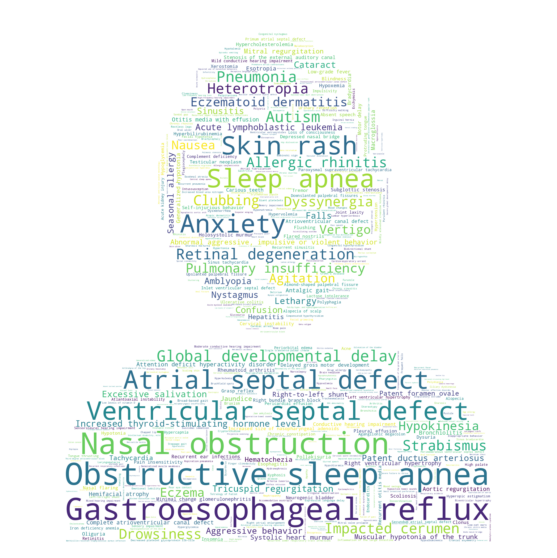

In [71]:
from PIL import Image
from wordcloud import WordCloud
from matplotlib import pyplot as plt
terms=Counter()
for patient in ds_patients:
    try:
        terms+=Counter(map(id_to_name.get,filtered_data[patient]))
        #terms=Counter({k: c for k, c in terms.items() if c < 2000})
    except:
        pass
    
terms.pop(None, None)
def makeImage(text):
    mask = np.array(Image.open("ds.png"))

    wc = WordCloud(width=1600, height=800, background_color="white", max_words=500, mask=mask)
    # generate word cloud
    wc.generate_from_frequencies(text)

    # show
    plt.figure(figsize=(20,10))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.savefig("wordcloud.png", dpi=600)

makeImage(terms)
print(terms)

### Makeshift tf-idf vectorization + NMF

In [74]:
idx = 0
txt=""
tfdata,tflabel=[],[]
for pat in filtered_data:
    tfdata.append(' '.join(filtered_data[pat]) + '.')
    if pat in ds_patients:
        tflabel.append(1)
    elif pat in control_patients:
        tflabel.append(0)

In [75]:
import numpy as np
 
from sklearn.feature_extraction.text import TfidfVectorizer
 
from sklearn.decomposition import NMF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tfdata)
idx_to_word = np.array(vectorizer.get_feature_names())

In [76]:
nmf = NMF(n_components=10, solver="mu")
 
W = nmf.fit_transform(X)
 
H = nmf.components_

/home/havrillaj/miniconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [77]:
for i, topic in enumerate(H):
 
    print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]])))

Topic 1: 0002321,0001252,0000750,0000739,0002090,0002020,0002018,0000988,0002013,hp
Topic 2: 0001289,0000217,0011950,0003781,0002013,0000988,0001742,0001337,0002527,0000001
Topic 3: 0100577,0012646,0000047,0006717,0000034,0100673,0010677,0100518,0000011,0000028
Topic 4: 0002248,0000112,0002321,0002018,0001891,0003193,0000858,0002650,0001061,0100607
Topic 5: 0030788,0002020,0000403,0031353,0000750,0001742,0040261,0011108,0000389,0410018
Topic 6: 0000618,0000577,0000639,0000518,0020046,0000646,0000565,0000546,0032012,0000486
Topic 7: 0000040,0003020,0003124,0001891,0007018,0003193,0000822,0010788,0001061,0012871
Topic 8: 0031244,0011331,0000246,0410323,0001047,0001742,0012395,0000964,0000976,0003193
Topic 9: 0001653,0001643,0002650,0008443,0001655,0003124,0001629,0005180,0010444,0000822
Topic 10: 0001822,0032191,0003401,0010890,0030840,0025238,0002527,0031955,0030839,0031364


In [78]:
# Importing all necessary libraries.
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances

#from sklearn.utils.extmath import _ravel
# Random state.
RS = 251193

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('white')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [79]:
def scatter(x, colors, cluster_n):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", cluster_n))

    # We create a scatter plot.
    f = plt.figure(figsize=(48, 48))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=100,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    label_dict = {0:'Control Patients', 1:'Down Syndrome Patients'}
    for i in range(cluster_n):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, label_dict[i], fontsize=64)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
    #ax.legend()    
    handles, labels  =  ax.get_legend_handles_labels()
    ax.legend(handles, ('1', '2'))
    return f, ax, sc, txts

In [80]:
digits_proj = TSNE(random_state=RS).fit_transform(W)

[0, 1]


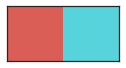

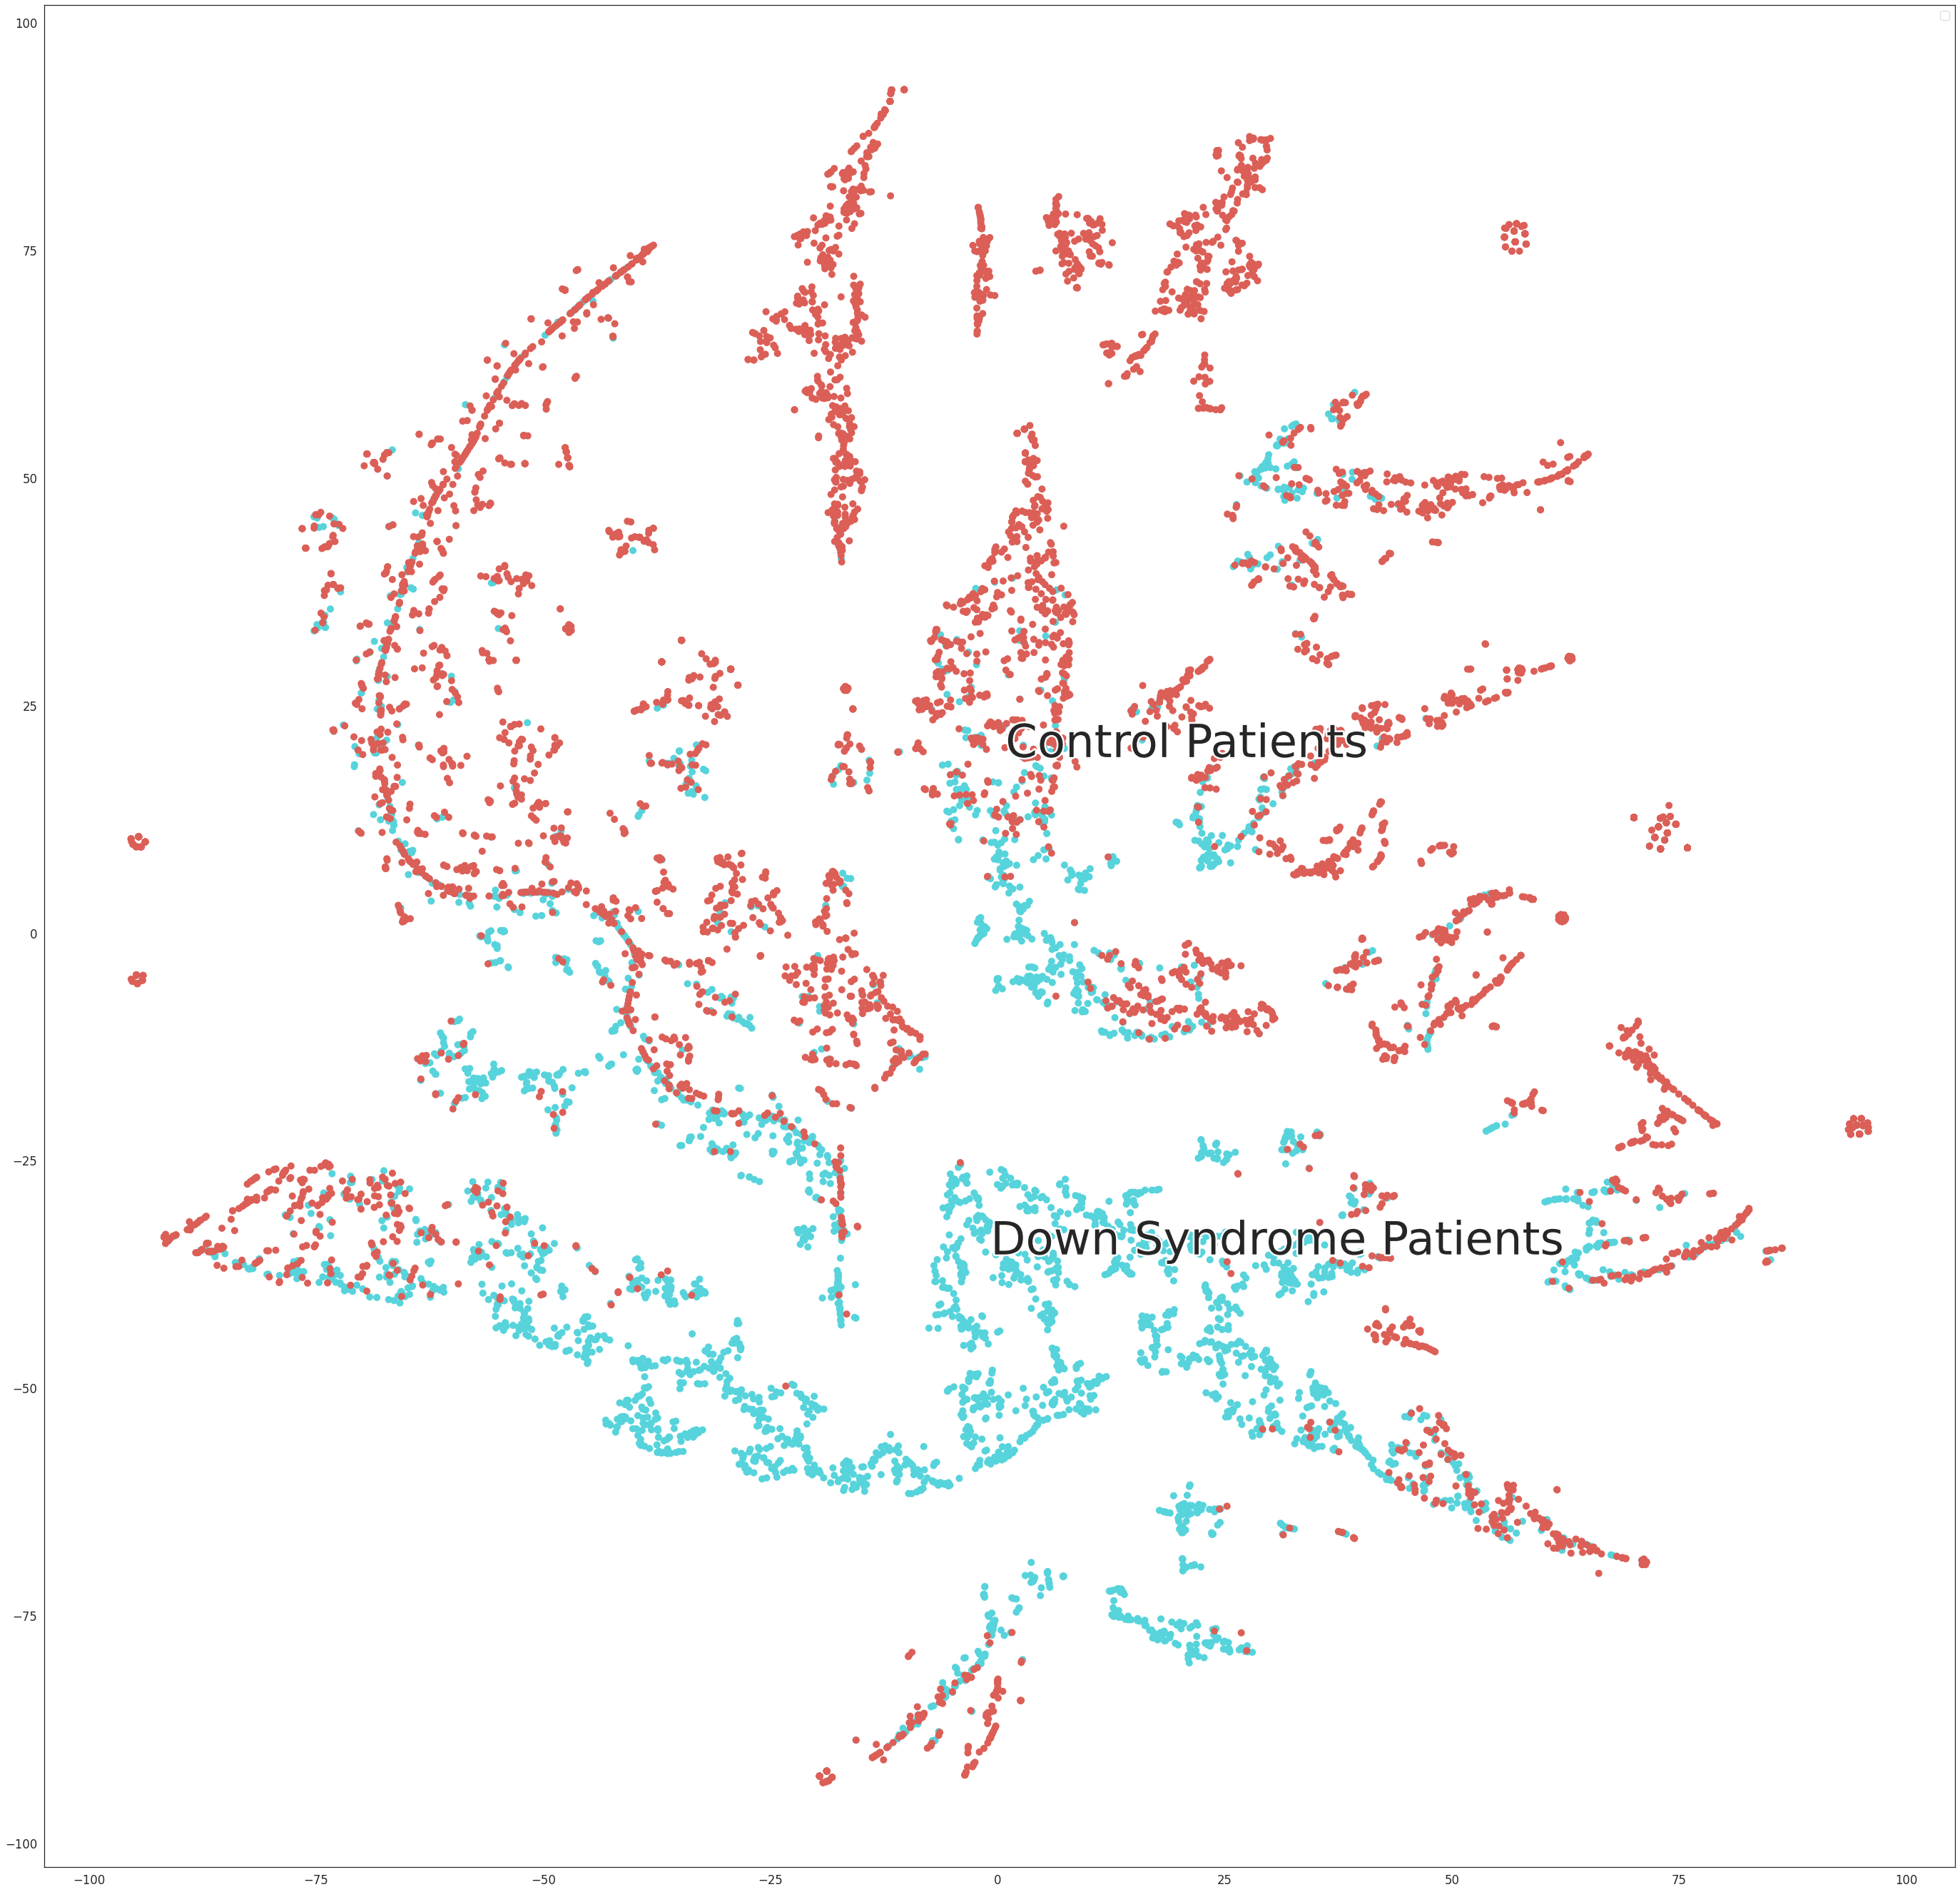

In [81]:
cluster_n = 2
savefig_name = 'clusterdsvcontrol.png'
print(list(range(0,cluster_n)))
sns.palplot(np.array(sns.color_palette("hls", cluster_n)))
scatter(digits_proj, np.array(tflabel), cluster_n)
plt.savefig(savefig_name, dpi=120)

### Parse OPA2Vec output to get HPO data

In [82]:

hpo_vectors = dict()

opa2vec_data = '/mnt/isilon/wang_lab/shared/apps/opa2vec/hpo.output'

In [83]:
vector_dict = {}
nl = False
cnt = 0
hp = ''
for line in open(opa2vec_data):
    
    if(len(line) <=1):
        nl = True
    if(line.startswith('<http')): 
        nl = False    
        hp = ''
    if(not nl ):
        if( 'HP_' in line): 
            data = line.split('> ')
            hp = data[0][-10:]
            if(vector_dict.get(hp) == None): vector_dict[hp] = data[1].rstrip('\n')
        elif(hp != ''):
            vector_dict[hp] += ' ' + line.rstrip('\n')

In [84]:
def str2vec(strdata):
    data = strdata.strip(' ').replace(' ', '\t')
    while('\t\t' in data):
        data = data.replace('\t\t', '\t')

    data = data.split('\t')
    for i in range(len(data)):
        data[i] = float(data[i])
    nparray = np.array(data)
    return nparray

In [85]:
hpo_vectors = dict()
for hp in vector_dict.keys():
    hpo_vectors[hp] = str2vec(vector_dict[hp])
    
len(hpo_vectors)

15803

In [86]:
### store the pat data into a dict and turn it to pd.dataframe later
to_df_data_dict = dict()

In [87]:
pat_vec = dict()

In [88]:
for p in filtered_data.keys():
    
    # skip the patients having no HPO data
    if(len(filtered_data[p]) < 1): continue
    
    hp_cnt = 0
    pvec = np.array([])
    
    for hp in filtered_data[p]:
        hp_cnt += 1
        hp  = hp.replace(':', '_')
        #print(hpo_vectors[hp])
        if(pvec.size == 0):
            pvec = hpo_vectors[hp]
        else:
            pvec = np.add(pvec, hpo_vectors[hp])
    #print(hp_cnt)        
    pat_vec[p] = pvec 

In [89]:
p_mtx = np.zeros( (len(pat_vec.keys()), len(pat_vec.keys()) ))
p_mtx.shape

(9735, 9735)

In [90]:
from scipy import spatial

In [91]:
cnt = 0
to_df_data_dict['pat'] = []

idx_pat_dict = dict()

pats = list(pat_vec.keys())

for i in range(len(pats)):
    
    for j in range(len(pats)):
        if(i == j): p_mtx[i,j] =0
        elif(i<j):
            p_mtx[i,j] = 1 - spatial.distance.cosine(pat_vec[pats[i]],pat_vec[pats[j]])
        else:
            p_mtx[i,j] = p_mtx[j,i]
    if((i+1) % 1000 == 0):
        print('calculated {} patients similarity vectors.'.format(str(i+ 1)))
        
    idx_pat_dict[i] = pats[i]
    cnt += 1
p_mtx.shape

calculated 1000 patients similarity vectors.
calculated 2000 patients similarity vectors.
calculated 3000 patients similarity vectors.
calculated 4000 patients similarity vectors.
calculated 5000 patients similarity vectors.
calculated 6000 patients similarity vectors.
calculated 7000 patients similarity vectors.
calculated 8000 patients similarity vectors.
calculated 9000 patients similarity vectors.


(9735, 9735)

In [1]:
## list pat id of first 10 in mtx

for i in range(10):
    print('{}\t{}'.format(str(i), idx_pat_dict[i]))

NameError: name 'idx_pat_dict' is not defined

### Use TSNE/UMAP and k-means/agglomerative hierarchical/DBSCAN clustering

In [93]:
import numpy as np
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os
import umap

In [94]:
# Importing all necessary libraries.
import numpy as np
from numpy import linalg
from numpy.linalg import norm
from scipy.spatial.distance import squareform, pdist

# We import sklearn and TSNE.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn.
from sklearn.metrics.pairwise import pairwise_distances

#from sklearn.utils.extmath import _ravel
# Random state.
RS = 251193

# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
%matplotlib inline

# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})

In [95]:
from sklearn.cluster import KMeans, AgglomerativeClustering

In [96]:
cluster_n = 3
kmeans = KMeans(n_clusters=cluster_n, random_state=100, algorithm="elkan", n_init=20, max_iter=400).fit(p_mtx)

In [65]:
ac = AgglomerativeClustering(n_clusters=cluster_n, affinity='euclidean', linkage='ward').fit(p_mtx)

In [97]:

Y=kmeans.labels_
to_df_data_dict['cluster'] = []

for i in range(len(Y)):
    to_df_data_dict['cluster'].append(Y[i])
Y


array([0, 2, 0, ..., 1, 2, 0], dtype=int32)

In [98]:
unique_labels = set(Y)
unique_labels

{0, 1, 2}

In [99]:
digits_proj = TSNE(random_state=RS,early_exaggeration=12).fit_transform(p_mtx)
#digits_proj = umap.UMAP(random_state=42,n_neighbors=15,min_dist=0.1).fit_transform(p_mtx)
#digits_proj = umap.UMAP(random_state=42,n_neighbors=40,min_dist=0.01).fit_transform(p_mtx)

In [100]:

def scatter(x, colors, cluster_n):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", cluster_n))

    # We create a scatter plot.
    f = plt.figure(figsize=(48, 48))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=100,
                    c=palette[colors.astype(np.int)])
    #plt.xlim(-25, 25)
    #plt.ylim(-25, 25)
    ax.axis('on')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(cluster_n):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=64)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

[0, 1, 2]


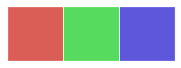

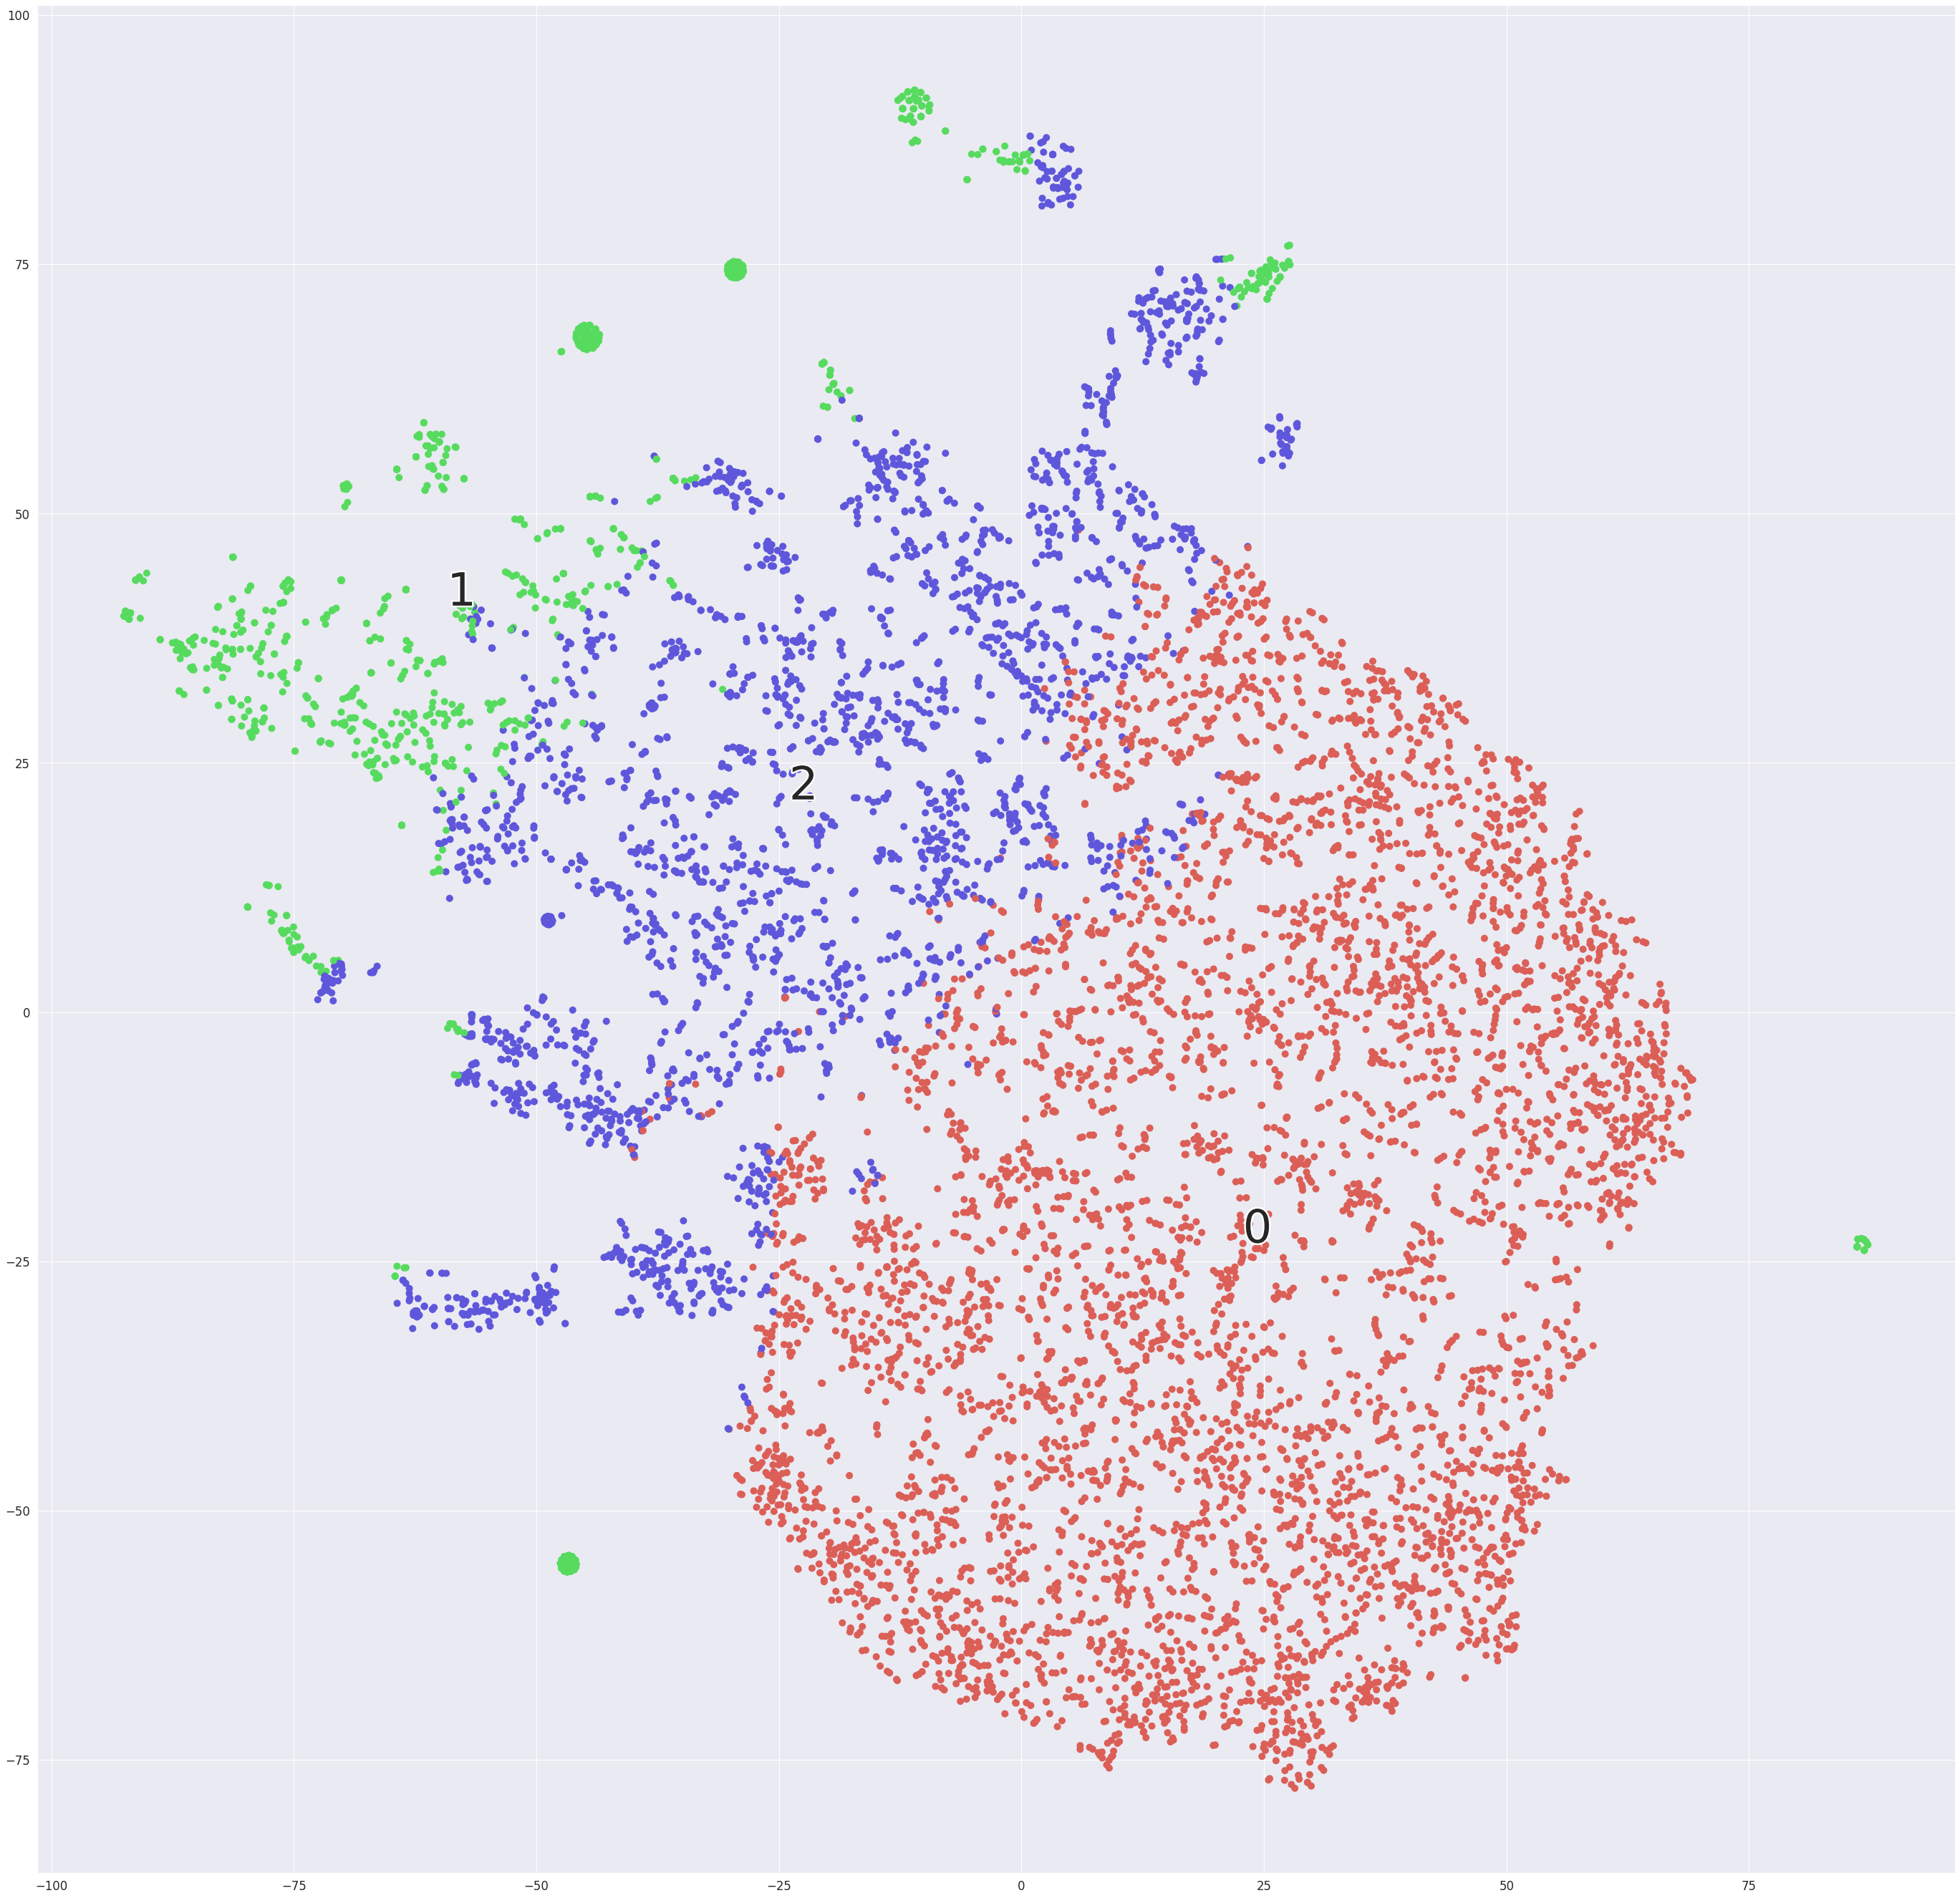

In [101]:
print(list(range(0,cluster_n)))
sns.palplot(np.array(sns.color_palette("hls", cluster_n)))
scatter(digits_proj, Y, cluster_n)
plt.savefig('tsne-test.png', dpi=120)

### Getting patient IDs for each cluster, and HPO terms

In [74]:
cluster = dict()
for clust in range(0,cluster_n):
    cluster[clust] = [idx_pat_dict[i] for i, x in enumerate(Y) if x == clust]

In [75]:
from collections import Counter, defaultdict
clustterms = defaultdict(Counter)
for clust in cluster:
    print(str(clust)+": "+str(len(cluster[clust])))
    for i in cluster[clust]:
        clustterms[clust]+=Counter(pat_hpo_data[i])
for i in clustterms:
    print(str(i) + ":"),
    print(sum([1 for x in cardiacterms if clustterms[i][x]]))
    print(sum([clustterms[i][x] for x in cardiacterms]))
    print(clustterms[i].most_common(10))

0: 3586
1: 5752
2: 762
0:
301
5695
[('HP:0012531', 2624), ('HP:0012393', 896), ('HP:0001945', 769), ('HP:0030148', 674), ('HP:0000822', 619), ('HP:0002013', 496), ('HP:0012735', 466), ('HP:0002099', 440), ('HP:0025267', 437), ('HP:0002019', 431)]
1:
562
51993
[('HP:0012531', 5458), ('HP:0001945', 4509), ('HP:0012735', 4119), ('HP:0012393', 4057), ('HP:0002013', 3976), ('HP:0002098', 3729), ('HP:0002094', 3359), ('HP:0000822', 3308), ('HP:0002099', 3225), ('HP:0002014', 3182)]
2:
126
588
[('HP:0012531', 282), ('HP:0000486', 69), ('HP:0032012', 69), ('HP:0012393', 69), ('HP:0000546', 65), ('HP:0000822', 58), ('HP:0001629', 56), ('HP:0000001', 44), ('HP:0100607', 40), ('HP:0001655', 34)]


In [76]:
#cluster 0 heart patients/total number of patients
print(67/243)
#cluster 1
print(275/1020)
#cluster 2
print(581/2885)

0.2757201646090535
0.2696078431372549
0.20138648180242635


### Getting ICD terms and heart related (I00-I99) for each patient cluster

In [77]:
#icdfile = "DS_patients_icds.tsv"
icdfile = "/mnt/isilon/wang_lab/shared/datasets/DownSyndromeData/DS_patients_icds.tsv"
paticd = dict()
with open(icdfile, "r") as icds:
    for line in icds:
        fields=line.strip().split("\t")
        patid=fields[0]; icds=fields[1].split("|")
        ## skip 22q deletion
        if(patid in pat_22q): continue
            
        paticd[patid]=icds


In [84]:
ct = dict()
for clust in cluster:
    ct[clust]=0
    try:
        for x in cluster[clust]:
            for y in paticd[x]:
                if y.startswith("I"):
                    ct[clust]+=1
                    break
                else:
                    try:
                        if(460>=float(y)>=390):
                            ct[clust]+=1
                            break
                    except ValueError:
                        continue
    except KeyError:
        continue
print(ct)

{0: 194, 1: 1548, 2: 47}
